## 小練習
請使用社群偵測法，找出2015年6月28號當天有哪些文章主題，並列舉該主題下的文章，文章數量與前十大主題關鍵字 (https://raw.githubusercontent.com/ywchiu/taipeifubon/master/data/20150628news.xlsx)

In [3]:
import pandas
news = pandas.read_excel('https://raw.githubusercontent.com/ywchiu/taipeifubon/master/data/20150628news.xlsx', index_col = 0)

### 斷字斷詞 (Jieba) 將中文斷詞以後, 轉變成英文斷詞方式

In [5]:
import jieba
jieba.load_userdict('userdict.txt')
corpus = []
titles = []
for idx, rec in news.iterrows():
    corpus.append(' '.join(jieba.cut(rec.get('description'))))
    titles.append(rec.get('title'))

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/46/b7dzk4mn6g54qzptv608w7d00000gn/T/jieba.cache
Loading model cost 0.699 seconds.
Prefix dict has been built succesfully.


### 建立詞頻矩陣  

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)

In [10]:
X

<147x11138 sparse matrix of type '<class 'numpy.longlong'>'
	with 22639 stored elements in Compressed Sparse Row format>

### 計算距離(cosine distance)

In [11]:
from sklearn.metrics.pairwise import cosine_distances
cs = cosine_distances(X)

In [12]:
cs.shape

(147, 147)

### 文章分群  (社群偵測法)

In [56]:
m = (cs < 0.8).astype(int)

In [57]:
import networkx as nx
G = nx.from_numpy_array(m)

In [58]:
G

In [59]:
import community
clusters = community.best_partition(G)

### 表列每一群的文章數量與代表關鍵字

In [60]:
from collections import Counter
c = Counter(list(clusters.values()))

In [61]:
c.most_common(10)

[(0, 36),
 (9, 17),
 (1, 11),
 (31, 7),
 (10, 4),
 (60, 3),
 (2, 2),
 (7, 2),
 (23, 2),
 (32, 2)]

In [62]:
import numpy as np
np_group = np.array(list(clusters.values()))

In [67]:
np_titles = np.array(titles)
np_titles[np_group == 31].tolist()

['旺報觀點－鄭弘儀！別讓台灣人背黑鍋！',
 '旺報觀點－紀念抗戰 台日中獲和解轉機',
 '紀念抗戰 學者：反省、避免戰爭',
 '多位台老兵 受邀赴陸閱兵',
 '首例 馬頒紀念章給新四軍老兵',
 '鄭弘儀反紀念抗戰 陸批數典忘祖',
 '中間選民為洪秀柱按讚']

In [77]:
np_features = np.squeeze(np.array(X[np_group==0].sum(axis = 0)))
len(np_features)

np.argsort(np_features)[::-1]

array([ 2292, 10168,  2595, ...,  7129,  7128,     0])

In [81]:
np_features_names = np.array(vectorizer.get_feature_names())
','.join(np_features_names[np.argsort(np_features)[::-1][0:10]].tolist())

'北市,醫院,台北市,樂園,馬偕,淡水,八仙,桃園市,臺北,粉塵'

In [82]:
for group, cnt in c.most_common(5):
    print('第{}群 - {}篇文章'.format(group, cnt))
    np_features = np.squeeze(np.array(X[np_group==group].sum(axis = 0)))
    print('代表關鍵字:',','.join(np_features_names[np.argsort(np_features)[::-1][0:10]].tolist()))
    print(np_titles[np_group == group].tolist()[0])
    print('====================================')

第0群 - 36篇文章
代表關鍵字: 北市,醫院,台北市,樂園,馬偕,淡水,八仙,桃園市,臺北,粉塵
八仙塵爆  五相關人依公共危險重傷害法辦
第9群 - 17篇文章
代表關鍵字: 最佳,專輯,公司,有限,音樂,演唱,國語,金曲獎,股份,蔡依林
蔡依林淚奪金曲 錦榮傳訊恭喜
第1群 - 11篇文章
代表關鍵字: 希臘,元區,經濟,政府,可能,表示,問題,民眾,債務,債權國
希臘國內三分一自動櫃員機現金短缺
第31群 - 7篇文章
代表關鍵字: 抗戰,國民黨,大陸,台灣,紀念,老兵,勝利,鄭弘儀,戰爭,八路軍
旺報觀點－鄭弘儀！別讓台灣人背黑鍋！
第10群 - 4篇文章
代表關鍵字: 中國,美國,中資,上市,企業,投資,公司,外資,台灣,a股
風評：陷入獵巫遊戲的中資認定


## 文章分類

In [83]:
import pandas
news = pandas.read_excel('https://raw.githubusercontent.com/ywchiu/taipeifubon/master/data/20171214news.xlsx', index_col = 0)

In [116]:
import jieba
jieba.load_userdict('userdict.txt')
titles = []
tags   = []
corpus = []
for idx, rec in news[news['category'].isin(['社會', '娛樂','政治'])].iterrows():
    titles.append(rec.get('title'))
    tags.append(rec.get('category'))
    corpus.append(' '.join(jieba.cut(rec.get('content'))))

In [117]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)

In [118]:
X

<331x14756 sparse matrix of type '<class 'numpy.longlong'>'
	with 45395 stored elements in Compressed Sparse Row format>

In [119]:
y = tags

In [120]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y,train_titles, test_titles = train_test_split(X,y,titles ,test_size = 0.2, random_state = 42)

In [121]:
train_X.shape

(264, 14756)

In [122]:
test_X.shape

(67, 14756)

In [123]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB(alpha = 0.01)
clf.fit(train_X, train_y)

MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)

In [124]:
predicted = clf.predict(test_X)

In [125]:
import numpy
target = numpy.array(test_y)
predicted == target 

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

In [126]:
(predicted == target).sum() / len(test_y)

0.9850746268656716

In [127]:
from sklearn.metrics import accuracy_score, confusion_matrix
accuracy_score(target, predicted)

0.9850746268656716

In [128]:
print(clf.classes_)
confusion_matrix(target, predicted)

['娛樂' '政治' '社會']


array([[24,  0,  0],
       [ 0, 18,  0],
       [ 1,  0, 24]])

In [129]:
np_test_titles = np.array(test_titles)
np_test_titles[predicted != target]

array(['小心！在美結婚台灣沒登記\u3000偷腥照樣能捉姦'], dtype='<U36')

In [108]:
article = '''
〔記者徐郁雯／台北報導〕張韶涵近年來把演藝重心轉往中國，她日前與前師妹郭靜同台，演唱過去與死對頭范瑋琪合唱歌曲《如果的事》，只見張韶涵一臉尷尬，硬唱100秒後馬上喊卡，讓網友看了啼笑皆非。
張韶涵難得與郭靜同台，本來要唱合唱過的歌曲《仨人》，但張韶涵坦言歌詞有點記不起來，郭靜反問要唱什麼？張韶涵回應：「我的歌！」郭靜表示：「《如果的事》嗎？」只見張韶涵表情尷尬，乾笑說：「喔…好。」
前奏一下，張韶涵、郭靜互看秒噴笑，敬業唱到一半時，張韶涵忽然受不了笑說：「好就這樣子，因為Delay了，掰掰。」隨後與郭靜擁抱、匆匆下台，但幽默氛圍仍受到不少討論。
'''

In [113]:
article_vec = vectorizer.transform([' '.join(jieba.cut(article))])

In [114]:
clf.predict(article_vec)

array(['娛樂'], dtype='<U2')

## 文章正負情緒判斷

In [132]:
import pandas
movies = pandas.read_excel('https://raw.githubusercontent.com/ywchiu/taipeifubon/master/data/yahoo_movie.xlsx', index_col = 0)


In [134]:
import jieba
jieba.load_userdict('userdict.txt')
corpus = []
tags   = []
for idx, rec in movies[movies['status'].isin(['good', 'bad'])].iterrows():
    corpus.append(' '.join(jieba.cut(rec['content'])))
    tags.append(rec['status'])

In [137]:
movies['title'].value_counts()

最終騎士       452
奧創紀元       281
攻殼機動隊      173
最後的絕地武士    117
古墓奇兵        89
Name: title, dtype: int64

In [135]:
len(tags)

980

In [166]:
stopwords = ['$', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '?', '_', '“', '”', '、', '。', '《', '》', '一', '一些', '一何', '一切', '一則', '一方面', '一旦', '一來', '一樣', '一般', '一轉眼', '萬一', '上', '上下', '下', '不', '不僅', '不但', '不光', '不單', '不只', '不外乎', '不如', '不妨', '不盡', '不盡然', '不得', '不怕', '不惟', '不成', '不拘', '不料', '不是', '不比', '不然', '不特', '不獨', '不管', '不至於', '不若', '不論', '不過', '不問', '與', '與其', '與其說', '與否', '與此同時', '且', '且不說', '且說', '兩者', '個', '個別', '臨', '為', '為了', '為什麼', '為何', '為止', '為此', '為著', '乃', '乃至', '乃至於', '麼', '之', '之一', '之所以', '之類', '烏乎', '乎', '乘', '也', '也好', '也罷', '了', '二來', '於', '於是', '於是乎', '云云', '云爾', '些', '亦', '人', '人們', '人家', '什麼', '什麼樣', '今', '介於', '仍', '仍舊', '從', '從此', '從而', '他', '他人', '他們', '以', '以上', '以為', '以便', '以免', '以及', '以故', '以期', '以來', '以至', '以至於', '以致', '們', '任', '任何', '任憑', '似的', '但', '但凡', '但是', '何', '何以', '何況', '何處', '何時', '余外', '作為', '你', '你們', '使', '使得', '例如', '依', '依據', '依照', '便於', '俺', '俺們', '倘', '倘使', '倘或', '倘然', '倘若', '借', '假使', '假如', '假若', '儻然', '像', '兒', '先不先', '光是', '全體', '全部', '兮', '關於', '其', '其一', '其中', '其二', '其他', '其餘', '其它', '其次', '具體地說', '具體說來', '兼之', '內', '再', '再其次', '再則', '再有', '再者', '再者說', '再說', '冒', '沖', '況且', '幾', '幾時', '凡', '凡是', '憑', '憑藉', '出於', '出來', '分別', '則', '則甚', '別', '別人', '別處', '別是', '別的', '別管', '別說', '到', '前後', '前此', '前者', '加之', '加以', '即', '即令', '即使', '即便', '即如', '即或', '即若', '卻', '去', '又', '又及', '及', '及其', '及至', '反之', '反而', '反過來', '反過來說', '受到', '另', '另一方面', '另外', '另悉', '只', '只當', '只怕', '只是', '只有', '只消', '只要', '只限', '叫', '叮咚', '可', '可以', '可是', '可見', '各', '各個', '各位', '各種', '各自', '同', '同時', '後', '後者', '向', '向使', '向著', '嚇', '嗎', '否則', '吧', '吧噠', '吱', '呀', '呃', '嘔', '唄', '嗚', '嗚呼', '呢', '呵', '呵呵', '呸', '呼哧', '咋', '和', '咚', '咦', '咧', '咱', '咱們', '咳', '哇', '哈', '哈哈', '哉', '哎', '哎呀', '哎喲', '嘩', '喲', '哦', '哩', '哪', '哪個', '哪些', '哪兒', '哪天', '哪年', '哪怕', '哪樣', '哪邊', '哪裡', '哼', '哼唷', '唉', '唯有', '啊', '啐', '啥', '啦', '啪達', '啷噹', '喂', '喏', '喔唷', '嘍', '嗡', '嗡嗡', '嗬', '嗯', '噯', '嘎', '嘎登', '噓', '嘛', '嘻', '嘿', '嘿嘿', '因', '因為', '因了', '因此', '因著', '因而', '固然', '在', '在下', '在於', '地', '基於', '處在', '多', '多麼', '多少', '大', '大家', '她', '她們', '好', '如', '如上', '如上所述', '如下', '如何', '如其', '如同', '如是', '如果', '如此', '如若', '始而', '孰料', '孰知', '寧', '寧可', '寧願', '寧肯', '它', '它們', '對', '對於', '對待', '對方', '對比', '將', '小', '爾', '爾後', '爾爾', '尚且', '就', '就是', '就是了', '就是說', '就算', '就要', '盡', '儘管', '儘管如此', '豈但', '己', '已', '已矣', '巴', '巴巴', '並', '並且', '並非', '庶乎', '庶幾', '開外', '開始', '歸', '歸齊', '當', '當地', '當然', '當著', '彼', '彼時', '彼此', '往', '待', '很', '得', '得了', '怎', '怎麼', '怎麼辦', '怎麼樣', '怎奈', '怎樣', '總之', '總的來看', '總的來說', '總的說來', '總而言之', '恰恰相反', '您', '惟其', '慢說', '我', '我們', '或', '或則', '或是', '或曰', '或者', '截至', '所', '所以', '所在', '所幸', '所有', '才', '才能', '打', '打從', '把', '抑或', '拿', '按', '按照', '換句話說', '換言之', '據', '據此', '接著', '故', '故此', '故而', '旁人', '無', '無寧', '無論', '既', '既往', '既是', '既然', '時候', '是', '是以', '是的', '曾', '替', '替代', '最', '有', '有些', '有關', '有及', '有時', '有的', '望', '朝', '朝著', '本', '本人', '本地', '本著', '本身', '來', '來著', '來自', '來說', '極了', '果然', '果真', '某', '某個', '某些', '某某', '根據', '歟', '正值', '正如', '正巧', '正是', '此', '此地', '此處', '此外', '此時', '此次', '此間', '毋寧', '每', '每當', '比', '比及', '比如', '比方', '沒奈何', '沿', '沿著', '漫說', '焉', '然則', '然後', '然而', '照', '照著', '猶且', '猶自', '甚且', '甚麼', '甚或', '甚而', '甚至', '甚至於', '用', '用來', '由', '由於', '由是', '由此', '由此可見', '的', '的確', '的話', '直到', '相對而言', '省得', '看', '眨眼', '著', '著呢', '矣', '矣乎', '矣哉', '離', '竟而', '第', '等', '等到', '等等', '簡言之', '管', '類如', '緊接著', '縱', '縱令', '縱使', '縱然', '經', '經過', '結果', '給', '繼之', '繼後', '繼而', '綜上所述', '罷了', '者', '而', '而且', '而況', '而後', '而外', '而已', '而是', '而言', '能', '能否', '騰', '自', '自個兒', '自從', '自各兒', '自後', '自家', '自己', '自打', '自身', '至', '至於', '至今', '至若', '致', '般的', '若', '若夫', '若是', '若果', '若非', '莫不然', '莫如', '莫若', '雖', '雖則', '雖然', '雖說', '被', '要', '要不', '要不是', '要不然', '要麼', '要是', '譬喻', '譬如', '讓', '許多', '論', '設使', '設或', '設若', '誠如', '誠然', '該', '說來', '諸', '諸位', '諸如', '誰', '誰人', '誰料', '誰知', '賊死', '賴以', '趕', '起', '起見', '趁', '趁著', '越是', '距', '跟', '較', '較之', '邊', '過', '還', '還是', '還有', '還要', '這', '這一來', '這個', '這麼', '這麼些', '這麼樣', '這麼點兒', '這些', '這會兒', '這兒', '這就是說', '這時', '這樣', '這次', '這般', '這邊', '這裡', '進而', '連', '連同', '逐步', '通過', '遵循', '遵照', '那', '那個', '那麼', '那麼些', '那麼樣', '那些', '那會兒', '那兒', '那時', '那樣', '那般', '那邊', '那裡', '都', '鄙人', '鑒於', '針對', '阿', '除', '除了', '除外', '除開', '除此之外', '除非', '隨', '隨後', '隨時', '隨著', '難道說', '非但', '非徒', '非特', '非獨', '靠', '順', '順著', '首先', '！', '，', '：', '；', '？', '「', '」', '（', '）']

In [167]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words=stopwords)
X = vectorizer.fit_transform(corpus)

In [168]:
X

<980x4688 sparse matrix of type '<class 'numpy.float64'>'
	with 14514 stored elements in Compressed Sparse Row format>

In [169]:
y = tags

In [170]:
X.shape

(980, 4688)

In [171]:
len(y)

980

In [172]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(X,y, test_size = 0.2 , random_state = 42)

In [173]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB(alpha = 0.01)
clf.fit(train_X, train_y)

MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)

In [174]:
predicted = clf.predict(test_X)

In [175]:
from sklearn.metrics import accuracy_score, confusion_matrix
accuracy_score(test_y ,predicted)

0.7551020408163265

In [176]:
from sklearn.metrics import accuracy_score, confusion_matrix
print(clf.classes_)
confusion_matrix(test_y ,predicted)

['bad' 'good']


array([[56, 25],
       [23, 92]])

In [178]:
import operator
coef_features= []

for index, features in enumerate(
                        zip(vectorizer.get_feature_names(), \
                        clf.feature_count_[0], \
                        clf.feature_count_[1])):
    feat,c1,c2 = features
    coef_features.append(tuple([c2/(c1 + 1), feat, c1, c2]))

for i in sorted(coef_features, key = lambda e: e[0], reverse=True)[0:20]:
    print(i)

(6.59760645567213, '不錯', 1.3140421164114147, 15.267139205933146)
(4.877553825419743, '好看', 6.756031354738384, 37.83046040437968)
(2.9198209468722123, '非常', 1.2677576685263265, 6.621446342993258)
(2.9175609476180706, '刺激', 0.5167478594386332, 4.425204322081459)
(2.8988744456448132, '爽片', 2.062276444611136, 8.877154930783277)
(2.862330174081765, '感動', 0.09403106378764493, 3.131478125262148)
(2.8120102325603624, '希望', 0.3084953875724313, 3.6795024191117136)
(2.8054758476171067, '奧創', 0.12763164693395296, 3.1635433504819055)
(2.775493120549073, '喜歡', 1.0641472259089721, 5.729026425310805)
(2.753369418843215, '還可以', 0.9355866000378334, 5.329384952066884)
(2.7231630669437914, '值得', 1.0752698444669953, 5.651298194394708)
(2.6042511853096264, '很爽', 0.27971851522153923, 3.3327084601283685)
(2.533817588811459, '其實', 0.6485647428185608, 4.177162341648109)
(2.4378702145165376, '相當', 0.0, 2.4378702145165376)
(2.2748378435629846, '效果', 0.0, 2.2748378435629846)
(2.158150205974589, '期待', 1.58993263145

## 小任務
- 使用剛剛的電影分類模型，試著讓電影分類模型判斷以下三個評論　何者為正向評論，何者為負向評論？

In [179]:
comments = ['的確是個好片，前面用詼諧誇張的方式慢慢鋪陳劇情，讓觀賞的人可以很容易進入劇情當中，而到後來像是坐雲霄飛車般的速度極速向下，讓人感到十分震撼，故事最後的結局也安置著十分巧妙，可以想像作者般在編劇上十分用心與巧思！', '比國小話劇社還爛的片 爛死 浪費時間', '一部有深度電影，看完會發人省思，包含從眾思維與跳脫思維，恐懼與希望等，藉由這次重新上映看到了老片的魅力']

In [180]:
corpus2 = []
for comment in comments:
    corpus2.append(' '.join(jieba.cut(comment)))
comment_vec = vectorizer.transform(corpus2)

In [181]:
comment_vec

<3x4688 sparse matrix of type '<class 'numpy.float64'>'
	with 40 stored elements in Compressed Sparse Row format>

In [182]:
clf.predict(comment_vec)

array(['good', 'bad', 'good'], dtype='<U4')

## Wordnet

In [183]:
! pip install nltk

In [184]:
import nltk
nltk.download('wordnet')


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/davidchiu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [185]:
from nltk.corpus import wordnet as wn
wn.synsets('motorcar')

[Synset('car.n.01')]

In [186]:
wn.synsets('trunk')

[Synset('trunk.n.01'),
 Synset('trunk.n.02'),
 Synset('torso.n.01'),
 Synset('luggage_compartment.n.01'),
 Synset('proboscis.n.02')]

In [187]:
wn.synset('car.n.01').lemma_names()

['car', 'auto', 'automobile', 'machine', 'motorcar']

## 計數手法

In [188]:
text  = 'You say goodbye and I say hello'

In [192]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
X = vectorizer.fit_transform([text])
X.toarray()

array([[1, 1, 1, 2, 1]], dtype=int64)

In [193]:
vectorizer.get_feature_names()

['and', 'goodbye', 'hello', 'say', 'you']

In [199]:
def preprocess(text):
    text = text.lower()
    text = text.replace('.', ' .')
    words = text.split(' ')
    word_to_id = {}
    id_to_word = {}
    for word in words:
        if word not in word_to_id:
            new_id = len(word_to_id)
            word_to_id[word] = new_id
            id_to_word[new_id] = word
    corpus = np.array([word_to_id[w] for w in words])
    return corpus, word_to_id, id_to_word

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

In [201]:
word_to_id

{'you': 0, 'say': 1, 'goodbye': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6}

In [202]:
id_to_word

{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}

In [200]:
corpus

array([0, 1, 2, 3, 4, 1, 5, 6])

In [203]:
def create_co_matrix(corpus, vocab_size, window_size=1):
    corpus_size = len(corpus)
    co_matrix = np.zeros((vocab_size, vocab_size), dtype=np.int32)
    
    for idx, word_id in enumerate(corpus):
        for i in range(1, window_size + 1):
            left_idx = idx - i
            right_idx = idx + i
            
            if left_idx >= 0:
                left_word_id = corpus[left_idx]
                co_matrix[word_id, left_word_id] += 1

            if right_idx < corpus_size:
                right_word_id = corpus[right_idx]
                co_matrix[word_id, right_word_id] += 1

    return co_matrix


In [206]:
text

'You say goodbye and I say hello.'

In [205]:
id_to_word

{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}

In [208]:
C = create_co_matrix(corpus, len(word_to_id), 1)
C

array([[0, 1, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 1, 0],
       [0, 1, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 1, 0, 0],
       [0, 1, 0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1, 0]], dtype=int32)

In [219]:
from sklearn.metrics.pairwise import cosine_similarity
cs = cosine_similarity(C)

In [220]:
cs.shape

(7, 7)

In [221]:
cs

array([[1.        , 0.        , 0.70710678, 0.        , 0.70710678,
        0.70710678, 0.        ],
       [0.        , 1.        , 0.        , 0.70710678, 0.        ,
        0.        , 0.5       ],
       [0.70710678, 0.        , 1.        , 0.        , 1.        ,
        0.5       , 0.        ],
       [0.        , 0.70710678, 0.        , 1.        , 0.        ,
        0.        , 0.        ],
       [0.70710678, 0.        , 1.        , 0.        , 1.        ,
        0.5       , 0.        ],
       [0.70710678, 0.        , 0.5       , 0.        , 0.5       ,
        1.        , 0.        ],
       [0.        , 0.5       , 0.        , 0.        , 0.        ,
        0.        , 1.        ]])

In [227]:
query = 'you'
def most_similiar(query, word_to_id, cs):
    #print(word_to_id.get(query))
    for pos in cs[0].argsort()[::-1]:
        print(pos, id_to_word.get(pos), cs[0][pos])
most_similiar(query, word_to_id, cs)

0 you 1.0
5 hello 0.7071067811865475
4 i 0.7071067811865475
2 goodbye 0.7071067811865475
6 . 0.0
3 and 0.0
1 say 0.0


In [229]:
def ppmi(C, verbose=False, eps = 1e-8):
    M = np.zeros_like(C, dtype=np.float32)
    N = np.sum(C)
    S = np.sum(C, axis=0)
    total = C.shape[0] * C.shape[1]
    cnt = 0
    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            pmi = np.log2(C[i, j] * N / (S[j]*S[i]) + eps)
            M[i, j] = max(0, pmi)
            if verbose:
                cnt += 1
                if cnt % (total//100) == 0:
                    print('%.1f%% done' % (100*cnt/total))
    return M



In [230]:
W = ppmi(C)
W

array([[0.       , 1.8073549, 0.       , 0.       , 0.       , 0.       ,
        0.       ],
       [1.8073549, 0.       , 0.8073549, 0.       , 0.8073549, 0.8073549,
        0.       ],
       [0.       , 0.8073549, 0.       , 1.8073549, 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 1.8073549, 0.       , 1.8073549, 0.       ,
        0.       ],
       [0.       , 0.8073549, 0.       , 1.8073549, 0.       , 0.       ,
        0.       ],
       [0.       , 0.8073549, 0.       , 0.       , 0.       , 0.       ,
        2.807355 ],
       [0.       , 0.       , 0.       , 0.       , 0.       , 2.807355 ,
        0.       ]], dtype=float32)

In [231]:
W.shape

(7, 7)

## SVD

In [232]:
import numpy as np
U, S, V = np.linalg.svd(W)


In [233]:
U.shape

(7, 7)

In [234]:
S.shape

(7,)

In [235]:
V.shape

(7, 7)

In [237]:
U[:,0]

array([ 3.4094876e-01,  0.0000000e+00,  4.3631220e-01,  1.1102230e-16,
        4.3631220e-01,  7.0923710e-01, -1.6653345e-16], dtype=float32)

In [238]:
U[:,1]

array([ 0.0000000e+00, -5.9763640e-01, -5.5511151e-17, -4.9782813e-01,
       -3.1237506e-17, -3.1237506e-17, -6.2848860e-01], dtype=float32)

Populating the interactive namespace from numpy and matplotlib


/Users/davidchiu/.pyenv/versions/3.6.2/lib/python3.6/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['rec', 'clf', 'text']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


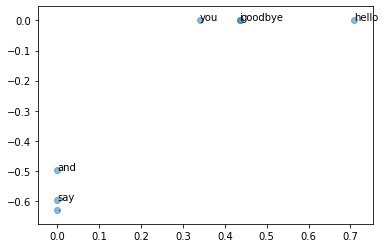

In [241]:
%pylab inline
from matplotlib import pyplot as plt
for word, word_id in word_to_id.items():
    plt.annotate(word, (U[word_id, 0], U[word_id, 1]))
plt.scatter(U[:,0], U[:,1], alpha=0.5)
plt.show()
